# Demo notebook to compute iterative N0 and N1 biases

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 

import plancklens 
from plancklens.utils import camb_clfile
from delensalot.biases import iterbiasesN0N1



mpisupport: False, pmisupport: False
disabling mpi
mpi.py: Plancklens.mpi disabled as per environ variable 



We use the Planck FFP10 power spectra as the default fiducial Cls

In [2]:
cls_path = os.path.join(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_unl_fid = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cpp_fid = cls_unl_fid['pp']

### Define analysis parameters

We start by defining the parameters used for the lensing reconstrcution.

In [3]:
# We consider a CMB-S4 configuration  
nlev_t = 1.
nlev_p = np.sqrt(2)
beam_fwhm = 1. 

# Range of CMB multipoles used in the reconstrcution 
lmin_ivf = (10, 10, 10)
lmax_ivf = 4000

# We compute the N0 and N1 bias up to lmax = 4000
lmax_qlm = 4000

In [4]:
# We define a directory to cache the results 
cachedir = 'n0n1_cachedir'


In [5]:
itbias = iterbiasesN0N1.iterbiases(nlev_t, nlev_p, beam_fwhm, lmin_ivf, lmax_ivf,
                                    lmax_qlm, cls_unl_fid, None, cachedir, verbose=True)
# Here we didnt specify the cls_noise_fid, they will be computed from the nlev_t, nlev_p and beam assuming a Gaussian noise

lmin_tlm:10, lmin_elm:10, lmin_blm:10
Filtering with gaussian beam and fiducial noise levels


### Computing the N0 and N1 

The QE noise levels are given for the iteration 0, while for the MAP we assume it converges at iteration 6 (might be worth to go up to 10 to be sure it has converged). 


Here we will loop over the QE and MAP estimators, and will compute the TT only, the Polarization only (EE+EB) and the Minimum variance N0 and N1 noise levels.
The complete iterations can take some time (about 2 seconds/iteration for TT, and about 2 min/iteration for the MV on a laptop).

We do not include the N1 in the iterations, i.e. it is not taken in the delensing efficiency, but we compute it for the final iteration


In [6]:
N0s = {}
N1s = {}

for itmax in [0, 6]:
    N0s[itmax] = {}
    N1s[itmax] = {}
    for qe_key in ['ptt', 'p_p', 'p']:
        print(f"Computing itmax:{itmax} for qe_key:{qe_key}")
        N0s[itmax][qe_key], N1s[itmax][qe_key], _, _ = itbias.get_n0n1(qe_key, itmax, None, None)

# Here we set as None the true CMB Cls and noise level, 
# you can change that if you want to compute the true (unbiased) 
# N0 and N1 of the map, assuming you know the Cls in the map.


Computing itmax:0 for qe_key:ptt
Computing itmax:0 for qe_key:p_p
Computing itmax:0 for qe_key:p
Computing itmax:6 for qe_key:ptt
Computing itmax:6 for qe_key:p_p
Computing itmax:6 for qe_key:p


### Some plots

In [7]:
def w(ell):
    return (ell*(ell+1))**2 * 1e7 * 2/np.pi

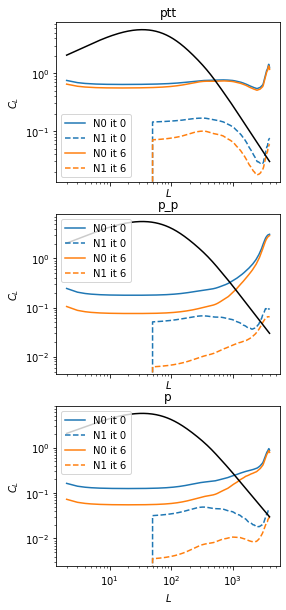

In [8]:
ls = np.arange(2, 4000)
fig, axs= plt.subplots(3, 1, figsize=(4, 10), sharex=True)
for ax, k in zip(axs, ['ptt', 'p_p', 'p']):
    for it, c in zip([0, 6], ['C0', 'C1']):
        ax.plot(ls, w(ls)*N0s[it][k][ls], label=f'N0 it {it}', c=c)
        ax.plot(ls, w(ls)*N1s[it][k][ls], label=f'N1 it {it}', c=c, ls='--')
    
    ax.plot(ls, w(ls)*cpp_fid[ls], c='k')
    ax.set_title(k)
    ax.legend()
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$C_L$')
    ax.set_xscale('log')
    ax.set_yscale('log')
